In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import uniform as sp_rand
from scipy.stats import randint
from sklearn.preprocessing import PolynomialFeatures


pd.set_option('display.max_columns', 300)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(palette="Dark2")

In [2]:
all_outliers = {}
results = {}
best_regressors = {}

In [3]:
"""Calculate RMSE"""
# def rmse(Y, Y_pred, apply_log=False):

#     if apply_log:
#         Z = np.log(Y) - np.log(Y_pred)
#     else:
#         Z = Y - Y_pred

#     return -np.sqrt(np.sum(Z**2)/len(Z))

def rmse(Y, Y_pred):
    Z = Y - Y_pred
    return -np.sqrt(np.sum(Z**2)/len(Z))

def log_rmse(Y, Y_pred):
    Z = np.log(Y) - np.log(Y_pred)
    return -np.sqrt(np.sum(Z**2)/len(Z))

rmse_scorer = make_scorer(rmse)
log_rmse_scorer = make_scorer(log_rmse)


In [4]:
def print_scores_ridge(GS, scorer, X, Y, Bayesian=False):
    if Bayesian:
        print("Best Parms : ", GS.best_params_)    
    else:
        print("Best alpha : ", GS.best_estimator_.alpha)
        
    print("Best R2 Score within CV : ", GS.best_score_)
    print("Best R2 Score on unseen test data", GS.best_estimator_.score(X, Y)) 
    print("Best RMSE Score on unseen test data", scorer(GS.best_estimator_.predict(X),Y))
    
    if(not Bayesian):
        x = GS.cv_results_["mean_test_rmse"]
        min = np.where(x == x.max())
        x_intercept  = GS.cv_results_["param_alpha"][min][0]
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        plt.title("Alpha vs RMSE")
        _ = sns.lineplot(x = GS.cv_results_["param_alpha"], y =  GS.cv_results_["mean_test_rmse"])
        _ = plt.axvline(GS.cv_results_["param_alpha"][min][0], color="purple")

        x = GS.cv_results_["mean_test_R2"]
        max = np.where(x == x.max())
        x_intercept  = GS.cv_results_["param_alpha"][max][0]
        plt.subplot(1,2,2)
        plt.title("Alpha vs R2")
        _ = sns.lineplot(x = GS.cv_results_["param_alpha"], y =  GS.cv_results_["mean_test_R2"])
        _ = plt.axvline(GS.cv_results_["param_alpha"][max][0], color="orange")
        _ = plt.axvline(GS.cv_results_["param_alpha"][min][0], color="purple")
        plt.show()



In [5]:
def get_top_and_bottom_coef(coef, train):
    coef_pd = pd.Series(coef, index = train.columns)
    imp_coef = pd.concat([coef_pd.sort_values().head(10),coef_pd.sort_values().tail(10)])
#     abs_coef = coef_pd.abs().sort_values()
    least_coef = coef_pd.abs().sort_values().head(20)
    
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.subplot(1,2,1)
    plt.title("Least important Coefficients")
    least_coef.plot(kind = "barh")
    plt.subplot(1,2,2)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.title("Most important Coefficients")
    imp_coef.plot(kind = "barh")
    plt.show()
    return (imp_coef, least_coef)

In [6]:
def print_scores_forest(GS, scorer, X, Y, Forest=True):
    rgsr = GS.best_estimator_
    print("Best parms : ", GS.best_params_)
    print("Best regressor : \n", rgsr)

    if(Forest):
        print("OOB Score  : ", rgsr.oob_score_)
    else:
        print("Best R2 score :",rgsr.score(X,Y))
    Y_pred = rgsr.predict(X)
    print("Best RMSE Score on unseen test data:", scorer(Y_pred,Y))
        
    temp = pd.DataFrame({"Prediction":Y_pred, "Actual": Y})
    _ = sns.lmplot(x = "Actual", y =  "Prediction",data = temp, height=8)
    plt.show()

In [7]:
def get_top_and_bottom_features(GS,train):
    rgsr = GS.best_estimator_
#     feature_import = pd.DataFrame(data=regressor.feature_importances_, index=X_scaled.columns.values, columns=['values'])
# feature_import.sort_values(['values'], ascending=False, inplace=True)
# feature_import.transpose()

    coef_pd = pd.Series(rgsr.feature_importances_, index = train.columns).sort_values(ascending=False)
    imp_coef = coef_pd.head(20)
    least_coef = coef_pd.abs().tail(20)
    
    plt.rcParams['figure.figsize'] = (16.0, 8.0)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.subplot(1,2,1)
    plt.title("Least important Coefficients")
    least_coef.plot(kind = "barh")
    plt.subplot(1,2,2)
#     plt.tight_layout(pad=0.4,w_pad=0.5, h_pad=1.0)
    plt.title("Most important Coefficients")
    imp_coef.plot(kind = "barh")
    plt.show()
    return (imp_coef, least_coef)

In [8]:
def get_outliers(Y_pred, Y, plot_fig = True):
    resid = Y - Y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    Z = (resid - mean_resid)/std_resid
    outliers = np.where(abs(Z) > abs(Z).std() * 3)[0]
    
    
    if(plot_fig):
        plt.figure(figsize=(8, 6))
        plt.scatter(Y, Y_pred, alpha=0.2)
        plt.scatter(Y[outliers], Y_pred[outliers])
        plt.show()
    
    return outliers

# Set 4
Ordinal : Yes <br>
Standardized : Yes <br>
Polynomial : Yes

In [9]:
set_num = "set4_"

def create_submission_file(set_str, filename, test_X, pred_Y, log_transform=False):
    sub_data = test_X.copy()
    if log_transform:
        pred_Y = np.exp(pred_Y)
    sub_data["SalePrice"] = pred_Y
    
    sub_data = sub_data[["SalePrice"]]
    
    file = "../data/submission/" + set_str + filename +".csv"
    sub_data.to_csv(file)
        


In [35]:
def create_submission_file2(set_str, filename, test_X, pred_Y, log_transform=False):

    if log_transform:
        pred_Y = np.exp(pred_Y)
    sub_data = pd.DataFrame({"Id": sub_index, "SalePrice": pred_Y})
    
    file = "../data/submission/" + set_str + filename +".csv"
    sub_data.to_csv(file)

In [25]:
poly = PolynomialFeatures(degree=2,interaction_only=True)


train_data = pd.read_csv("../data/processed_data/train_processed_set1.csv",index_col=0)
submission_data = pd.read_csv("../data/processed_data/test_processed_set1.csv",index_col=0)

sub_index = submission_data.index

print(train_data.shape)
print(submission_data.shape)

X = train_data.drop("SalePrice", axis=1)
Y2 = np.log(train_data["SalePrice"])
Y = train_data["SalePrice"]

X = poly.fit_transform(X)
submission_data = poly.fit_transform(submission_data)


train_X, test_X, train_Y, test_Y = train_test_split(X, Y,test_size=0.2, random_state=99)
# train_X, test_X, train_Y, test_Y = train_test_split(train_data.iloc[:,:-1], train_data.iloc[:,-1:],test_size=0.2, random_state=99)

train_X2, test_X2, train_Y2, test_Y2 = train_test_split(X, Y2,test_size=0.2, random_state=99)



print("\n")
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

print("\n")
print(train_X2.shape)
print(train_Y2.shape)
print(test_X2.shape)
print(test_Y2.shape)


(1460, 202)
(1460, 201)


(1168, 20302)
(1168,)
(292, 20302)
(292,)


(1168, 20302)
(1168,)
(292, 20302)
(292,)


In [11]:
train_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,HeatingQC,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,SalePrice,Age,AgeRemod,TotalArea,TotalSF,TotalFullBaths,TotalHalfBaths,TotalPorch,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_1,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_None,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_None,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBsmt,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBsmt,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NoBsmt,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_1,CentralAir_Y,Electrical_1,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,PavedDrive_P,PavedDrive_Y,PoolArea_Yes,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Remod_True
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.232170,-0.217879,0.646183,-0.509081,0.529034,1.039805,-0.230047,0.577094,0.141836,0.602047,-0.293025,-0.934165,0.885619,0.413547,0.169927,-0.207698,0.737021,0.986849,0.237316,-0.925990,-0.978830,0.316333,0.307986,0.349364,0.27738,0.267611,-0.831532,208500,1.046258,0.896833,-0.217200,0.023003,1.346257,1.021796,-0.261852,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,

In [12]:
train_X.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
train_Y.head()

In [ ]:
train_Y2.head()

# Ridge with Y

In [13]:
estimator = Ridge(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e3,500)}
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 13 s, sys: 735 ms, total: 13.8 s
Wall time: 18min 4s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, random_state=55, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': array([1.00000e-02, 2.01399e+00, ..., 9.97996e+02, 1.00000e+03])}],
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score='warn',
       scoring={'rmse': make_scorer(log_rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  805.6131663326653
Best R2 Score within CV :  -0.1363630084346893
Best R2 Score on unseen test data 0.9243529545046136
Best RMSE Score on unseen test data -0.11134710311622868


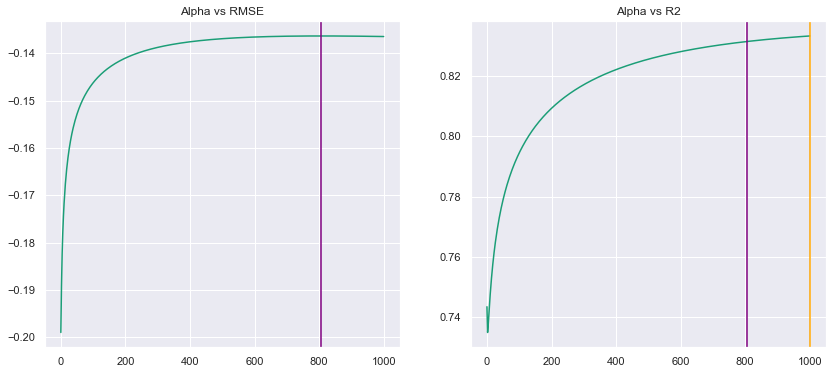

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [20]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


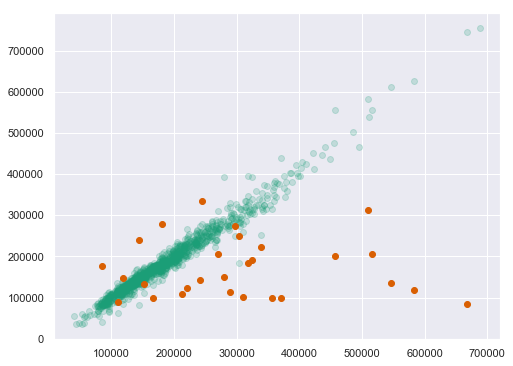

In [21]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["Ridge"] = outliers

In [28]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Ridge"] = pred_Y
best_regressors["Ridge"] = grid_search.best_estimator_
create_submission_file2(set_num, "Ridge", submission_data, pred_Y, log_transform=False)

In [ ]:
all_outliers


In [ ]:
results

# Ridge with log(Y)

In [39]:
# estimator = Ridge(random_state=55, max_iter=2000)
# cvs = 5
param_grid = {'alpha': np.linspace(1e-2,1e4,500)}


custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid ,cv=cvs, n_iter = 50,scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 2.16 s, sys: 250 ms, total: 2.41 s
Wall time: 1min 54s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, random_state=55, solver='auto', tol=0.001),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha': array([1.00000e-02, 2.00501e+01, ..., 9.97996e+03, 1.00000e+04])},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  1322.6539679358716
Best R2 Score within CV :  -0.1304911657144428
Best R2 Score on unseen test data 0.9174472378598402
Best RMSE Score on unseen test data -0.10338605596474876


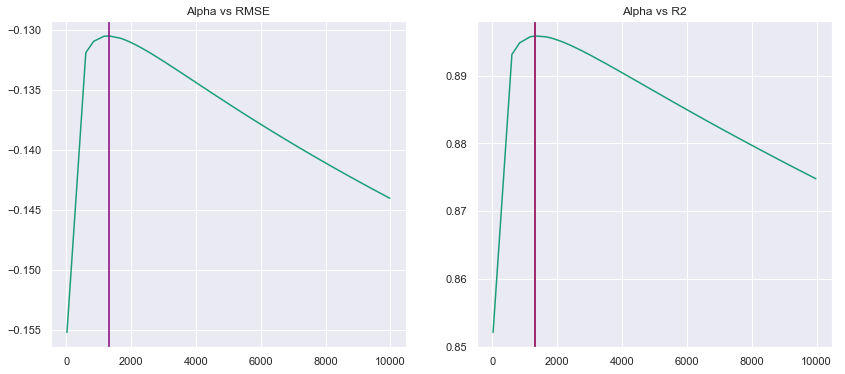

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [40]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


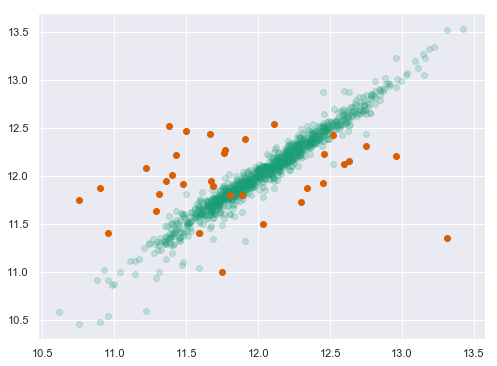

In [41]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["Ridge_Log"] = outliers

In [42]:
all_outliers

{'Ridge': array([   5,   52,   92,   96,  116,  117,  148,  209,  276,  292,  389,
         452,  457,  480,  576,  585,  606,  636,  646,  647,  701,  721,
         738,  772,  802,  857,  977,  979, 1059, 1069, 1151]),
 'Ridge_Log': array([   5,   18,   25,   32,   50,   75,   92,   96,   97,  115,  116,
         117,  129,  148,  240,  276,  389,  452,  480,  492,  512,  559,
         585,  589,  601,  636,  646,  718,  738,  807,  848,  857,  938,
         977, 1000, 1013, 1041, 1048, 1069, 1101, 1151])}

In [43]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Ridge_Log"] = np.exp(pred_Y)
best_regressors["Ridge_Log"] = grid_search.best_estimator_
create_submission_file2(set_num, "Ridge_Log", submission_data, pred_Y, log_transform=True)

In [55]:
rgsr = best_regressors.get("Ridge_Log")
rgsr.fit(X, Y2)

Ridge(alpha=1322.6539679358716, copy_X=True, fit_intercept=True,
   max_iter=2000, normalize=False, random_state=55, solver='auto',
   tol=0.001)

In [56]:
rgsr.score(test_X2, test_Y2)

0.9581446615278435

In [57]:
pred = rgsr.predict(test_X2)
rmse(test_Y2, pred)

-0.07361589434024608

In [59]:
pred = rgsr.predict(submission_data)
create_submission_file2(set_num, "Ridge_Log_full_fit", submission_data, pred, log_transform=True)


# Lasso with Y

In [ ]:
estimator = Lasso(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e3,500)}
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["Lasso"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Lasso"] = pred_Y
best_regressors["Lasso"] = grid_search.best_estimator_
create_submission_file(set_num, "Lasso", submission_data, pred_Y, log_transform=False)

# Lasso with log(Y)

In [44]:
estimator = Lasso(random_state=55, max_iter=2000)
cvs = 5
param_grid = {'alpha': np.linspace(1e-4,1e4,500)}


custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_iter=50, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 1.69 s, sys: 237 ms, total: 1.93 s
Wall time: 1min 36s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=55,
   selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'alpha': array([1.00000e-04, 2.00402e+01, ..., 9.97996e+03, 1.00000e+04])},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  2685.370814629259
Best R2 Score within CV :  -0.4081897476189645
Best R2 Score on unseen test data -0.003788784228138331
Best RMSE Score on unseen test data -0.3605100140712293


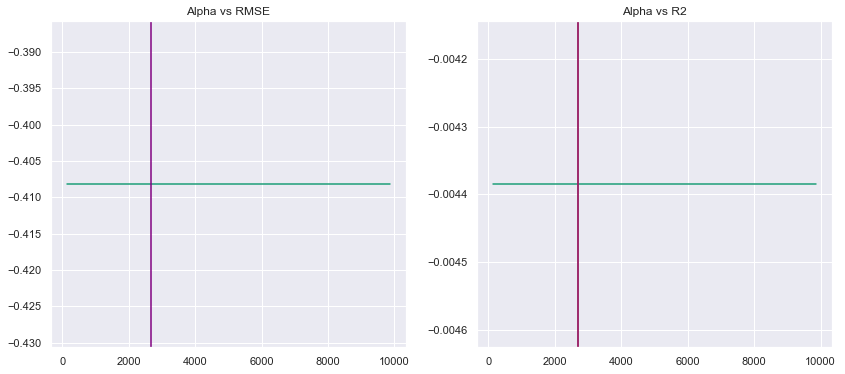

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [45]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["Lasso_Log"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Lasso_Log"] = np.exp(pred_Y)
best_regressors["Lasso_Log"] = grid_search.best_estimator_
create_submission_file2(set_num, "Lasso_log", submission_data, pred_Y, log_transform=True)

# ElasticNet with Y

In [ ]:
estimator = ElasticNet(random_state=55, max_iter=2000)
cvs = 5
param_grid = [
    {'alpha': np.linspace(1e-2,1e1,20),
     "l1_ratio" : np.linspace(0,1,10)
    }
]

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["ENet"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet"] = pred_Y
best_regressors["ENet"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet", submission_data, pred_Y, log_transform=False)

# ElasticNet with Y - Using RandomizedSearchCV for faster search

In [ ]:
estimator = ElasticNet(random_state=55, max_iter=2000)
cvs = 5
param_grid = {
    'alpha': np.linspace(1e-4,1e-2,200),
    "l1_ratio" : sp_rand()
    }

custom_scoring = {"rmse" : log_rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_distributions=param_grid ,cv=cvs, scoring=custom_scoring, n_iter=50,n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet2"] = pred_Y
best_regressors["ENet2"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet2", submission_data, pred_Y, log_transform=False)

# ElasticNet with log(Y)

In [ ]:
estimator = ElasticNet(random_state=55, max_iter=3000)
cvs = 5

param_grid = [
    {'alpha': np.linspace(1e-4,1e-2,20),
     "l1_ratio" : np.linspace(0,1,10)
    }
]

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = GridSearchCV(estimator, param_grid ,cv=cvs, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

In [ ]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X2)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["ENet_Log"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet_Log"] = np.exp(pred_Y)
best_regressors["ENet_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "ENet_Log", submission_data, pred_Y, log_transform=True)

# ElasticNet with log(Y) - Using RandomizedSearchCV for faster search

In [46]:
estimator = ElasticNet(random_state=55, max_iter=3000)
cvs = 5

param_grid = {
    'alpha': np.linspace(1e-4,1e+2,500),
    "l1_ratio" : np.linspace(0,1,100)
    }


custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid ,cv=cvs,n_iter=100, scoring=custom_scoring, n_jobs=-1, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

CPU times: user 4.82 s, sys: 296 ms, total: 5.11 s
Wall time: 5min 43s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=55, selection='cyclic', tol=0.0001, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'alpha': array([1.00000e-04, 2.00501e-01, ..., 9.97996e+01, 1.00000e+02]), 'l1_ratio': array([0.    , 0.0101, ..., 0.9899, 1.    ])},
          pre_dispatch='2*n_jobs', random_state=None, refit='rmse',
          return_train_score='warn',
          scoring={'rmse': make_scorer(rmse), 'R2': 'r2'}, verbose=0)

Best alpha :  2.004106012024048
Best R2 Score within CV :  -0.15711163304580408
Best R2 Score on unseen test data 0.88523763661203
Best RMSE Score on unseen test data -0.12189781054365047


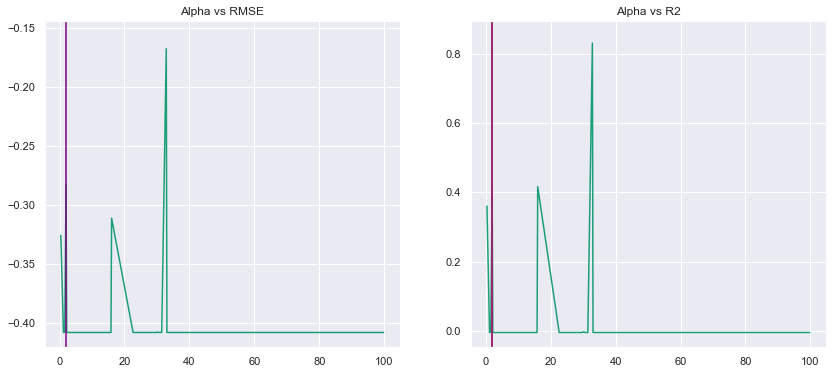

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [47]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


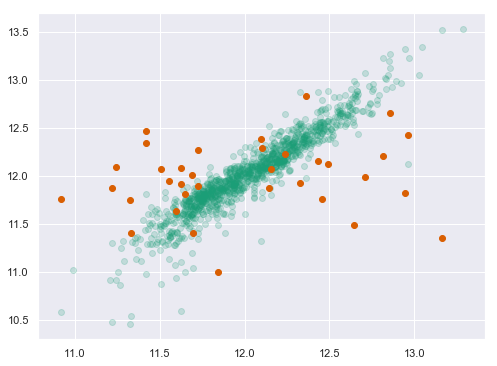

In [48]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["ENet_Log2"] = outliers

In [49]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ENet_Log2"] = np.exp(pred_Y)
best_regressors["ENet_Log2"] = grid_search.best_estimator_
create_submission_file2(set_num, "ENet_Log2", submission_data, pred_Y, log_transform=True)

# Bayesian Ridge with Y

In [50]:
estimator = BayesianRidge()

param_grid = {
    "alpha_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "alpha_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],

}
custom_scoring = {"rmse" : "neg_mean_squared_error", "R2": "r2"}

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=50, scoring=custom_scoring, refit="rmse")
%time grid_search.fit(train_X, train_Y)

KeyboardInterrupt: 

In [ ]:
print_scores_ridge(grid_search, log_rmse, test_X, test_Y, Bayesian=True)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["BayRidge"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["BayRidge"] = pred_Y
best_regressors["BayRidge"] = grid_search.best_estimator_
create_submission_file2(set_num, "BayRidge", submission_data, pred_Y, log_transform=False)

# Bayesian Ridge with log(Y)

In [ ]:
estimator = BayesianRidge()

param_grid = {
    "alpha_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "alpha_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_1": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],
    "lambda_2": [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e+1,1e+2],

}
custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=50, scoring=custom_scoring, refit="rmse")
%time grid_search.fit(train_X2, train_Y2)

In [ ]:
print_scores_ridge(grid_search, rmse, test_X2, test_Y2, Bayesian=True)
_ = get_top_and_bottom_coef(grid_search.best_estimator_.coef_, train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["BayRidge_Log"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["BayRidge_Log"] = np.exp(pred_Y)
best_regressors["BayRidge_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "BayRidge_Log", submission_data, pred_Y, log_transform=True)

# Randomforest with Y 

In [ ]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto", "sqrt", "log2", 0.2, 0.4,0.6,0.8]
    }

custom_scoring = {"rmse" : rmse_scorer, "R2": "r2"}
grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100)
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["RF"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["RF"] = pred_Y
best_regressors["RF"] = grid_search.best_estimator_
create_submission_file(set_num, "RF", submission_data, pred_Y)

# Randomforest with Y - Using Grid Search to override MSE with Log RMSE

In [ ]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto",]
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,  cv=5, n_iter=100,scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["RF2"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["RF2"] = pred_Y
best_regressors["RF2"] = grid_search.best_estimator_
create_submission_file(set_num, "RF2", submission_data, pred_Y, log_transform=True)

# Randomforest with log(Y) - Using Grid Search to override MSE with Log RMSE

In [ ]:
estimator = RandomForestRegressor(random_state=55, oob_score=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),
    "max_features": ["auto", "sqrt", "log2", 0.2, 0.4,0.6,0.8]
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1,  cv=5, n_iter=100,scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

In [ ]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["RF_Log2"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["RF_Log2"] = np.exp(pred_Y)
best_regressors["RF_Log2"] = grid_search.best_estimator_
create_submission_file(set_num, "RF_Log2", submission_data, pred_Y, log_transform=True)

# ExtraTrees with Y - Using Grid Search to override MSE with Log RMSE

In [ ]:
estimator = ExtraTreesRegressor(random_state=55, oob_score=True, bootstrap=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),

    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["Extra"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["Extra"] = pred_Y
best_regressors["Extra"] = grid_search.best_estimator_
create_submission_file(set_num, "Extra", submission_data, pred_Y)

# ExtraTrees with log(Y) - Using Grid Search to override MSE with Log RMSE

In [ ]:
estimator = ExtraTreesRegressor(random_state=55, oob_score=True, bootstrap=True)

param_grid = {
    "n_estimators": randint(10,100),
    "max_depth" : randint(5,50),

    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=100, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

In [ ]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["Extra_Log"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["ExtraLog"] = np.exp(pred_Y)
best_regressors["ExtraLog"] = grid_search.best_estimator_
create_submission_file(set_num, "Extra_Log", submission_data, pred_Y, log_transform=True)

# GradientBoost with Y

In [ ]:
estimator = GradientBoostingRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["GB"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["GB"] = pred_Y
best_regressors["GB"] = grid_search.best_estimator_
create_submission_file(set_num, "GB", submission_data, pred_Y)

# GradientBoost with log(Y)

In [60]:
estimator = GradientBoostingRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

KeyboardInterrupt: 

In [ ]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["GB_Log"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["GB_Log"] = np.exp(pred_Y)
best_regressors["GB_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "GB_Log", submission_data, pred_Y, log_transform=True)

# XGBoost with Y

In [ ]:
estimator = XGBRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=log_rmse_scorer)
%time grid_search.fit(train_X, train_Y)

In [ ]:
print_scores_forest(grid_search, log_rmse, test_X, test_Y, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X)
outliers = get_outliers(train_Y, pred_Y)
all_outliers["XGB"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["XGB"] = pred_Y
best_regressors["XGB"] = grid_search.best_estimator_
create_submission_file(set_num, "XGB", submission_data, pred_Y)

# XGBoost with log(Y)

In [ ]:
estimator = XGBRegressor(random_state=55)

param_grid = {
    "n_estimators": randint(10,150),
    "max_depth" : randint(5,50),    
    }

grid_search = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=5, n_iter=20, scoring=rmse_scorer)
%time grid_search.fit(train_X2, train_Y2)

In [ ]:
print_scores_forest(grid_search, rmse, test_X2, test_Y2, Forest=False)
_ = get_top_and_bottom_features(grid_search,train_X)

In [ ]:
pred_Y = grid_search.best_estimator_.predict(train_X2)
outliers = get_outliers(train_Y2, pred_Y)
all_outliers["XGB_Log"] = outliers

In [ ]:
pred_Y = grid_search.best_estimator_.predict(submission_data)
results["XGB_Log"] = np.exp(pred_Y)
best_regressors["XGB_Log"] = grid_search.best_estimator_
create_submission_file(set_num, "XGB_Log", submission_data, pred_Y, log_transform=True)

In [ ]:
def store_results(set_str,results):
    df = pd.DataFrame(results)
    file = "../data/submission/" + set_str + "all_results.csv"
    df.to_csv(file)

In [ ]:
store_results(set_num,results)

In [ ]:
all_outliers

In [ ]:
outlier_dict = {}
for key,value in all_outliers.items():
#     print((value[0]))
#     outlier_list.append(list(value))
#     np.concatenate(outlier_list,value)
    print(list(value))
    for i in list(value):
        if outlier_dict.get(i,0) == 0:
            outlier_dict[i] = 1
        else:
             outlier_dict[i]+=1

In [ ]:
outlier_dict

In [ ]:
[print(key, value) for key,value in outlier_dict.items() if value>8]

In [ ]:
from sklearn.neural_network import MLPRegressor
rgsr = MLPRegressor(max_iter=20000, learning_rate='adaptive', learning_rate_init=0.01,
                   random_state=55, hidden_layer_sizes=(50,))
%time rgsr.fit(train_X, train_Y)
print(rgsr.score(train_X, train_Y))
print(rgsr.score(test_X, test_Y))
print(log_rmse(rgsr.predict(test_X),test_Y))
print(rgsr.n_iter_)

In [63]:
from sklearn.neural_network import MLPRegressor
rgsr = MLPRegressor(max_iter=10000,  learning_rate_init=0.01,
                   random_state=55, hidden_layer_sizes=(400,100))
%time rgsr.fit(train_X2, train_Y2)
print(rgsr.score(train_X2, train_Y2))
print(rgsr.score(test_X2, test_Y2))
print(rmse(rgsr.predict(test_X2),test_Y2))
print(rgsr.n_iter_)

CPU times: user 4min 55s, sys: 19.4 s, total: 5min 15s
Wall time: 2min 43s
0.9841668345811755
-4.742680833596534
-0.8622903051926842
103


In [ ]:
from sklearn.svm import svr, 